In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(3198)

def rational_approximation(t):

    # Abramowitz and Stegun formula 26.2.23.
    # The absolute value of the error should be less than 4.5 e-4.
    c = [2.515517, 0.802853, 0.010328]
    d = [1.432788, 0.189269, 0.001308]
    numerator = (c[2]*t + c[1])*t + c[0]
    denominator = ((d[2]*t + d[1])*t + d[0])*t + 1.0
    return t - numerator / denominator

def normal_cdf_inverse(p):
    p[p <= 0.5] = -rational_approximation( np.sqrt(-2.0*np.log(p[p <= 0.5])) )
    p[p > 0.5] = rational_approximation( np.sqrt(-2.0*np.log(1.0-p[p > 0.5])) )
    return p

def get_brownian_bridge_indices(max_index):
    bb_indices = np.zeros(max_index + 1, np.int32)
    bb_indices[0] = 0
    bb_indices[1] = max_index
    bb_parents = [None] * (max_index + 1)
    j = 2
    index_pairs = [[0,max_index]]
    continue_flag = True
    while continue_flag:
        continue_flag = False
        i = 0
        index_pairs_new = index_pairs.copy()
        for pair in index_pairs:
            if pair[1] > pair[0] + 1:
                continue_flag = True
                middle = math.ceil((pair[0] + pair[1]) / 2)
                index_pairs_new[i] = [pair[0], middle]                
                index_pairs_new.append([middle, pair[1]])
                bb_indices[j] = middle
                bb_parents[j] = pair
                i += 1
                j += 1
        index_pairs = index_pairs_new        
    return bb_indices, bb_parents

In [4]:
paths = 10
max_t = 21
t = np.transpose(np.tile(np.arange(0,max_t), (paths, 1)))
n = t.shape[0]
m = t.shape[1]
u = np.random.uniform(0,1,(n,m))
z = normal_cdf_inverse(u)

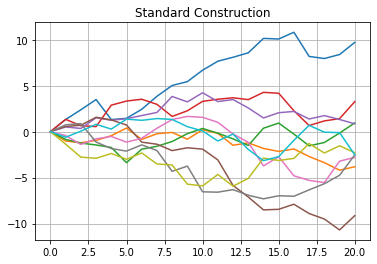

In [5]:
# Standard construction of the Wiener process
i = np.arange(0,n - 1)
dw = z[1:,:] * np.sqrt(t[i+1,:] - t[i,:])
w = np.insert(np.cumsum(dw, axis=0), 0, 0.0, axis=0)

fig = plt.figure()
ax = plt.axes()
ax.plot(t, w)
ax.grid()
plt.title("Standard Construction");

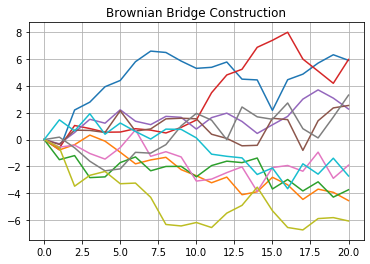

In [6]:
# Brownian Bridge construction of the Wiener process
bb_indices, bb_parents = get_brownian_bridge_indices(n - 1)

w_bb = np.zeros((n,m))
w_bb[0,:] = 0.0
w_bb[n-1,:] = np.sqrt(t[n-1] - t[0]) * z[1]
jacobian = np.zeros((n,n,m))
jacobian[n-1,1,:] = np.sqrt(t[n-1] - t[0])
for i in range(2, n):
    # indices of current step and its parents
    bi = bb_indices[i]
    p0 = bb_parents[i][0]
    p1 = bb_parents[i][1]
    
    # time coordinates of current step and its parents
    si = t[p0]
    ui = t[p1]
    ti = t[bi]
    
    # values of the parents of the Wiener process at ti
    ws = w_bb[p0]
    wu = w_bb[p1]
        
    zi = z[i]
    cs = (ui - ti)/(ui - si)
    cu = (ti - si)/(ui - si)
    cz = np.sqrt(cs*cu*(ui - si))
    
    # Brownian bridge calculation
    w_bb[bi] = cs*ws + cu*wu + cz*zi
    
    # sensitivity of Wiener process at ti to all the normals
    jacobian[bi] = jacobian[p0]*cs + jacobian[p1]*cu
    jacobian[bi,i] += cz
    
fig = plt.figure()
ax = plt.axes()
ax.plot(t, w_bb)
ax.grid()
plt.title("Brownian Bridge Construction");

Text(0.5, 1.0, 'Heatplot of the Jacobian: $\\partial B_i / \\partial Z_j$')

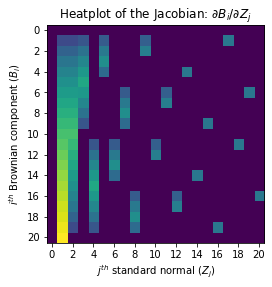

In [7]:
# Display the Jacobian: derivative of the Wiener process at ti with respect to the jth standard normal

path = 0
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(np.sqrt(jacobian[:,:,path]))
ax.set_xticks(np.arange(0, n, 2));
ax.set_yticks(np.arange(0, n, 2));
plt.xlabel('$j^{th}$ standard normal ($Z_j$)')
plt.ylabel('$i^{th}$ Brownian component ($B_i$)')
plt.title('Heatplot of the Jacobian: $\partial B_i / \partial Z_j$')

### Total Sensitivity:

Let $t = t_0, t_1, \ldots, t_n$ and $W_i$ be the Winer process at $t = t_i$ for $i = 0, 1, \ldots, n$. Then the following condition holds:

\begin{equation}
\frac{\partial W_i}{\partial \mathbf{z}} \cdot \frac{\partial W_i}{\partial \mathbf{z}} = t_i - t_0,
\end{equation}

where $\mathbf{z} = [z_0, z_1, \ldots, z_n]$ is the vector of standard normals used in the construction of the Wiener process.

In [8]:
assert (np.abs(np.sum(jacobian * jacobian, axis=1) - (t - t[0])) < 1e-14).all(), "The statement is not true!"